# 0. Загрузка необходимых библиотек

In [22]:
from preparation import DataRepresentation

In [23]:
import pandas as pd
import io
import numpy as np
import re
from pandasql import sqldf

# 1. Представление датасетов

Для грамотного представления датасетов была создана специальная функция, которая бы объединила бы листы файлов в один датасет

In [24]:
repr = DataRepresentation()
history = repr.transform('./dataset/Исторический состав (неполный) - 2023_2024 - зашифрованный.xlsx', ['2022', '2023'], 'Год', 0)
history_x = repr.transform('./dataset/Исторический состав (неполный) - 2023_2024 - зашифрованный.xlsx', ['2022_ч', '2023_ч'], 'Год', 0)
elstations = repr.transform('./dataset/Перечень электростанций - зашифрованный.xlsx', ['2022', '2023'], 'Год', 0)
weather = repr.transform('./dataset/Погода (Нью-Йорк - Бостон).xlsx', ['НьюЙорк', 'Бостон'], 'Город', 0)
elstations_info = repr.transform('./dataset/Показатели станций 22-23_зашифрованные.xlsx', ['22_23'], None, 0)
prediction = repr.transform('./dataset/Состав на прогноз - зашифрованный.xlsx', ['2024'], None, 0)
price = repr.transform('./dataset/Цена т.у.т. - зашифрованная.xlsx', ['Лист1'], None, 0)
price_pred = repr.transform('./dataset/Цена т.у.т. на прогноз - 2024.xlsx', ['Лист1'], None, 0)
price_rsv = repr.transform('./dataset/Цены РСВ 2022-2023 - зашифрованные.xlsx', ['Цены РСВ 2024'], None, 0)

# 2. Работа с данными

## 2.1. Исторический состав (неполный) - 2023_2024 - зашифрованный

In [25]:
history['stantsiya'] = repr.values_to_latin(history, 'stantsiya')
history[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = history[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].replace('-', '0')
history[['god', 'mesyats', 'chislo']] = history[['god', 'mesyats', 'chislo']].astype(int)
history.head(5)

,mesyats,chislo,stantsiya,1,2,3,4,5,6,7,8,9,10,god
0,1,1,modnaya,1,1,1,1,0,0,0,0,0,0,2022
1,1,1,kozyrnaya,1,1,0,0,0,1,0,0,0,0,2022
2,1,1,novaya,1,0,1,0,0,0,0,0,0,0,2022
3,1,1,stilnaya,1,1,1,0,0,0,0,0,0,0,2022
4,1,1,bespontovaya,0,0,0,0,0,0,1,0,1,0,2022


## 2.2. Перечень электростанций - зашифрованный

In [26]:
elstations['naimenovanie gtp generatsii'] = repr.values_to_latin(elstations, 'naimenovanie gtp generatsii')
elstations[['god']] = elstations[['god']].astype(int)
elstations['gen.oborudovanie'] = elstations['gen.oborudovanie'].astype(str)

#elstations['gorod'] = np.where(elstations['gorod'] == 'НьюЙорк', 'Уфа', 'Стерлитамак')
elstations.head(5)

,gorod,naimenovanie gtp generatsii,"ustanovlennaya moshchnost stantsii, mvt",gen.oborudovanie,"ustanovlennaya moshchnost, mvt",minimum,god
0,Нефтекамск,kozyrnaya,1856.2,1,315.2,140.0,2022
1,Нефтекамск,kozyrnaya,1856.2,2,300.0,140.0,2022
2,Нефтекамск,kozyrnaya,1856.2,4,300.0,140.0,2022
3,Нефтекамск,kozyrnaya,1856.2,5,300.0,140.0,2022
4,Нефтекамск,kozyrnaya,1856.2,6,324.7,140.0,2022


### 2.2.1. Перечень электростанций - установленная мощность по оборудованию

In [27]:
elstations_mvt = elstations.pivot_table(index=['god', 'gorod', 'naimenovanie gtp generatsii'], columns='gen.oborudovanie', values='ustanovlennaya moshchnost, mvt')
elstations_mvt.reset_index(inplace=True)
elstations_mvt.rename(columns={'naimenovanie gtp generatsii': 'stantsiya'}, inplace=True)
elstations_mvt.head(5)

gen.oborudovanie,god,gorod,stantsiya,1,10,2,3,4,5,6,7,8,9
0,2022,Благовещенск (Башкирия),stilnaya,60.0,NaN,60.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,Бостон,novaya,60.0,NaN,60.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,Бостон,staraya,NaN,50.0,NaN,NaN,60.0,60.0,50.0,NaN,NaN,100.0
3,2022,Нефтекамск,kozyrnaya,315.2,NaN,300.0,316.3,300.0,300.0,324.7,NaN,NaN,NaN
4,2022,Нью-Йорк,chetverka,NaN,45.0,NaN,NaN,NaN,NaN,60.0,60.0,60.0,45.0


### 2.2.2. Перечень электростанций - минимум

In [28]:
elstations_min = elstations.pivot_table(index=['god', 'gorod', 'naimenovanie gtp generatsii'], columns='gen.oborudovanie', values='minimum')
elstations_min.reset_index(inplace=True)
elstations_min.rename(columns={'naimenovanie gtp generatsii': 'stantsiya'}, inplace=True)
elstations_min.head(5)

gen.oborudovanie,god,gorod,stantsiya,1,10,2,3,4,5,6,7,8,9
0,2022,Благовещенск (Башкирия),stilnaya,25.0,NaN,25.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,Бостон,novaya,25.0,NaN,25.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,Бостон,staraya,NaN,10.0,NaN,NaN,25.0,25.0,10.0,NaN,NaN,50.0
3,2022,Нефтекамск,kozyrnaya,140.0,NaN,140.0,137.0,140.0,140.0,140.0,NaN,NaN,NaN
4,2022,Нью-Йорк,chetverka,NaN,5.0,NaN,NaN,NaN,NaN,30.0,30.0,30.0,5.0


### 2.2.4. Перечень электростанций - установленная мощность станций

In [29]:
elstations_moschnost = elstations[['god', 'naimenovanie gtp generatsii', 'ustanovlennaya moshchnost stantsii, mvt']].drop_duplicates()
elstations_moschnost.columns = ['god', 'stantsiya', 'moschnost']
elstations_moschnost.head(5)

,god,stantsiya,moschnost
0,2022,kozyrnaya,1856.2
6,2022,stilnaya,210.0
9,2022,lyubimaya,519.0
15,2022,moya,95.0
20,2022,chetverka,270.0


## 2.3. Показатели станций 22-23_зашифрованные

In [30]:
elstations_info['stantsiya'] = repr.values_to_latin(elstations_info, 'stantsiya')
elstations_info[['god', 'mesyats', 'den']] = elstations_info[['god', 'mesyats', 'den']].astype(int)
elstations_info['znachenie'] = elstations_info['znachenie'].astype(str).apply(lambda x: x.replace(u'\xa0', '').replace(',', '.')).astype(float)
elstations_info['atribut'] = elstations_info['atribut'].apply(lambda x: '_'.join(x.replace('э/э', '').replace('на', '').replace('  ', '').strip().split(' ')[:-1]))
elstations_info['atribut'] = repr.values_to_latin(elstations_info, 'atribut')
elstations_info = pd.pivot_table(elstations_info, index=['god', 'mesyats', 'den', 'stantsiya'], columns='atribut', values='znachenie')
elstations_info.reset_index(inplace=True)
elstations_info.head(5)

atribut,god,mesyats,den,stantsiya,obshchiy_raskhod_uslovnogo_topliva,otpusk_tepla,otpusks_shin,raskhod,raskhod_toplivaotpusk_tepla,sobstvennye_nuzhdy,sobstvennye_nuzhdy_otpusk_tepla,udelnyy_raskhod_topliva,udelnyy_raskhod_toplivateplo,vyrabotka
0,2022,1,1,bespontovaya,1662.0,6253.0,2508.686,779.0,883.0,63.1525,97.2055,310.52,141.21,2798.243
1,2022,1,1,chetverka,2004.0,7421.0,3203.141,986.0,1018.0,88.5585,71.9930,307.82,137.18,3502.224
2,2022,1,1,kozyrnaya,3646.0,390.0,10792.240,3581.0,65.0,190.6860,17.0070,331.81,166.67,11179.776
3,2022,1,1,lyubimaya,4335.0,16441.0,9712.365,2361.0,1974.0,184.7115,231.7080,243.09,120.07,10515.154
4,2022,1,1,modnaya,2360.0,945.0,8920.278,2223.0,137.0,63.2415,6.1275,249.21,144.97,9051.336


## 2.4. Состав на прогноз - зашифрованный

In [31]:
prediction['year'] = 2024
prediction['stantsiya'] = repr.values_to_latin(prediction, 'stantsiya')
prediction[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = prediction[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].replace('-', '0')
prediction[['mesyats', 'chislo']] = prediction[['mesyats', 'chislo']].astype(int)
prediction.head(5)

,mesyats,chislo,stantsiya,1,2,3,4,5,6,7,8,9,10,year
0,1,1,modnaya,1,1,1,1,0,0,0,0,0,0,2024
1,1,1,kozyrnaya,1,0,1,0,0,1,0,0,0,0,2024
2,1,1,novaya,0,1,1,0,0,0,0,0,0,0,2024
3,1,1,stilnaya,1,0,1,0,0,0,0,0,0,0,2024
4,1,1,bespontovaya,0,0,0,0,0,0,1,0,1,0,2024


## 2.5. Цена т.у.т. - зашифрованная

In [32]:
price[['god', 'mesyats']] = price[['god', 'mesyats']].astype(int)
price = pd.melt(price, id_vars=['god', 'mesyats'], value_vars=['kozyrnaya', 'lyubimaya', 'moya', 'chetverka', 'stilnaya', 'staraya', 'novaya', 'bespontovaya', 'modnaya'])
price.columns = ['god', 'mesyats', 'stantsiya', 'price']
price.head(5)

,god,mesyats,stantsiya,price
0,2022,1,kozyrnaya,4320.66
1,2022,2,kozyrnaya,4322.16
2,2022,3,kozyrnaya,3606.82
3,2022,4,kozyrnaya,3609.26
4,2022,5,kozyrnaya,3620.22


## 2.6. Цена т.у.т. на прогноз - 2024

In [33]:
price_pred['stantsiya'] = repr.values_to_latin(price_pred, 'stantsiya')
price_pred = pd.melt(price_pred, id_vars=['stantsiya'], value_vars=[1, 2, 3, 4, 5, 6])
price_pred['god'] = 2024
price_pred.head(5)

,stantsiya,variable,value,god
0,kozyrnaya,1,4285.84,2024
1,moya,1,4311.67,2024
2,lyubimaya,1,4809.48,2024
3,chetverka,1,4953.73,2024
4,staraya,1,4551.74,2024


## 2.9. Цены РСВ 2022-2023 - зашифрованные

In [34]:
price_rsv = pd.melt(price_rsv, id_vars=['data'], value_vars=['kozyrnaya', 'lyubimaya', 'moya', 'chetverka', 'stilnaya', 'staraya', 'novaya', 'bespontovaya', 'modnaya'])
price_rsv = repr.date_transform(price_rsv, 'data')
price_rsv[['god', 'mesyats', 'chislo']] = price_rsv[['god', 'mesyats', 'chislo']].astype(int)
price_rsv = price_rsv.drop_duplicates()
price_rsv.head(5)

,variable,value,chislo,mesyats,god,chas
0,kozyrnaya,1041.98,1,1,2022,0
1,kozyrnaya,1022.77,1,1,2022,1
2,kozyrnaya,1012.22,1,1,2022,2
3,kozyrnaya,975.77,1,1,2022,3
4,kozyrnaya,960.47,1,1,2022,4


# 3. Формирование датасета для обучения

In [35]:
from statistic import CorrelationTests
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 3.1. Объединение данных

In [36]:
sql_query = '''
SELECT 
    h.mesyats, 
    h.chislo, 
    h.stantsiya,
    h.god,
    ev."1", 
    ev."2", 
    ev."3",
    ev."4", 
    ev."5", 
    ev."6", 
    ev."7", 
    ev."8", 
    ev."9", 
    ev."10",
    em.moschnost,
    price, 
    elst.obshchiy_raskhod_uslovnogo_topliva as target
FROM 
    history as h
LEFT JOIN
    elstations_mvt as ev ON h.stantsiya = ev.stantsiya AND h.god = ev.god
LEFT JOIN
    elstations_moschnost as em ON h.stantsiya = em.stantsiya AND h.god = em.god
LEFT JOIN
    price as pr ON h.mesyats = pr.mesyats AND h.god = pr.god AND h.stantsiya = pr.stantsiya
LEFT JOIN
    elstations_info as elst ON h.mesyats = elst.mesyats AND h.chislo = elst.den AND h.god = elst.god AND h.stantsiya = elst.stantsiya
'''
dataset_raskhod = sqldf(sql_query, locals())
dataset_raskhod = dataset_raskhod.fillna(0)
dataset_raskhod.head(5)

,mesyats,chislo,stantsiya,god,1,2,3,4,5,6,7,8,9,10,moschnost,price,target
0,1,1,modnaya,2022,160.0,60.0,220.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,3991.14,2360.0
1,1,1,kozyrnaya,2022,315.2,300.0,316.3,300.0,300.0,324.7,0.0,0.0,0.0,0.0,1856.2,4320.66,3646.0
2,1,1,novaya,2022,60.0,60.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,4377.26,2221.0
3,1,1,stilnaya,2022,60.0,60.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,4393.66,1003.0
4,1,1,bespontovaya,2022,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,60.0,60.0,180.0,4390.31,1662.0


## 3.2. Подготовка данных моделированию

In [37]:
numerical_columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'moschnost', 'price']
categorical_columns = ['stantsiya', 'god', 'mesyats', 'chislo']

In [38]:
le = LabelEncoder()
for column in categorical_columns:
    dataset_raskhod[column] = le.fit_transform(dataset_raskhod[column])
#sc = StandardScaler()
#for column in numerical_columns:
    #dataset_raskhod[column] = le.fit_transform(dataset_raskhod[[column]])

## 3.4. Проверка данных перед моделированием

In [39]:
correlation = CorrelationTests(dataset_raskhod[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'moschnost', 'price', 'target']])
correlation.pearson_correlation()['target']

1            0.754243
2            0.726001
3            0.654617
4            0.889605
5            0.884062
6            0.895046
7           -0.055490
8            0.070836
9           -0.190382
10          -0.258256
moschnost    0.900917
price        0.090393
target       1.000000
Name: target, dtype: float64

In [40]:
X = dataset_raskhod.drop('target', axis=1)
y = dataset_raskhod['target']

# 4. Моделирование

In [41]:
from models import Model
import matplotlib.pyplot as plt

## 4.1. RandomForestRegressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

['moschnost', '5', '2', '6', '3', '1', '4', 'mesyats', 'chislo', 'price']
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
RMSE =  574.2283449621636


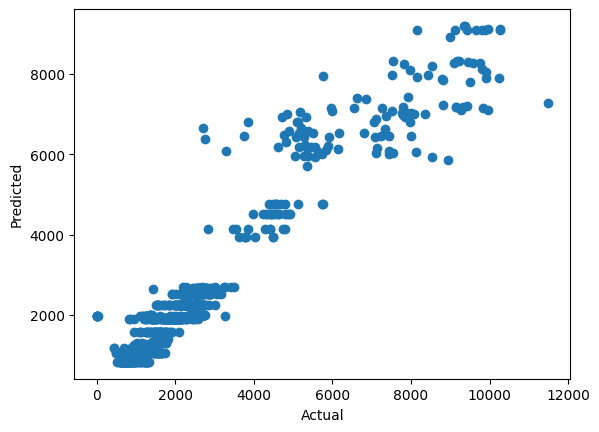

In [43]:
rf_param_grid = {'n_estimators': [100, 200, 300],
             'max_depth': [5, 10, 20],
             'min_samples_leaf': [5, 10, 15],
             'min_samples_split': [5, 10, 15],
        }

rf_model = RandomForestRegressor()     

model = Model(rf_model, rf_param_grid)
X = model.feature_importances(X, y, 10)

best_params = model.grid_search(X, y)

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X, y, test_size=0.2, random_state=42)

cur_rfc_model = RandomForestRegressor(**best_params)
cur_rfc_model.fit(X_rf_train, y_rf_train)
y_rf_pred = cur_rfc_model.predict(X_rf_test)

rmse = np.sqrt(mean_squared_error(y_rf_test, y_rf_pred))
print(f'RMSE =  {rmse}')

plt.scatter(y_rf_test, y_rf_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

## 4.2. Gradient Boosting Regressor

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

['moschnost', '5', '3', '4', '2', '1', 'mesyats', 'price', '6', 'chislo']
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
RMSE =  390.59460614416724


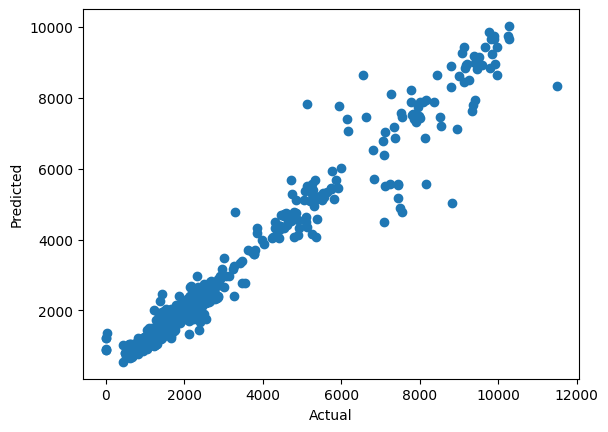

In [45]:
gb_param_grid = {'n_estimators': [200, 300, 500],
             'max_depth': [10, 20, 50],
             'learning_rate': [0.1, 0.01, 0.001]
}

gb_model = GradientBoostingRegressor()

model = Model(gb_model, gb_param_grid)
X = model.feature_importances(X, y, 12)

best_params = model.grid_search(X, y)

X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X, y, test_size=0.2, random_state=42)

cur_gb_model = GradientBoostingRegressor(**best_params)
cur_gb_model.fit(X_gb_train, y_gb_train)
y_gb_pred = cur_gb_model.predict(X_gb_test)

rmse = np.sqrt(mean_squared_error(y_gb_test, y_gb_pred))
print(f'RMSE =  {rmse}')

plt.scatter(y_gb_test, y_gb_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

## 4.3. Decision Tree Regresor

In [46]:
from sklearn.tree import DecisionTreeRegressor

['3', 'moschnost', 'mesyats', 'chislo', 'price', '6', '5', '1', '2', '4']
{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}
RMSE =  598.2588478652935


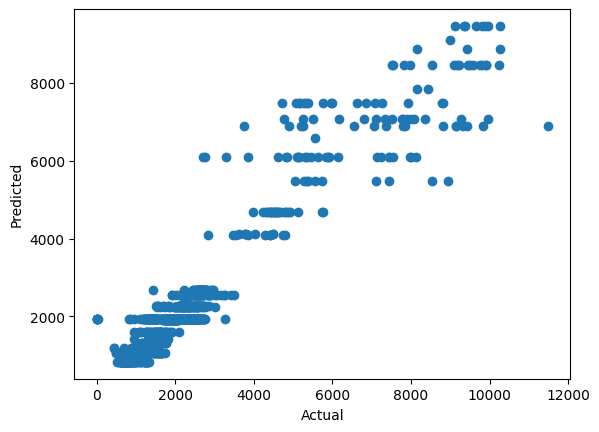

In [47]:
dt_param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

dt_model = DecisionTreeRegressor()

model = Model(dt_model, dt_param_grid)
X = model.feature_importances(X, y, 12)

best_params = model.grid_search(X, y)

X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X, y, test_size=0.2, random_state=42)

cur_dt_model = DecisionTreeRegressor(**best_params)
cur_dt_model.fit(X_dt_train, y_dt_train)
y_dt_pred = cur_dt_model.predict(X_dt_test)

rmse = np.sqrt(mean_squared_error(y_dt_test, y_dt_pred))
print(f'RMSE =  {rmse}')

plt.scatter(y_dt_test, y_dt_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# 5. Прогнозирование

In [48]:
sql_query = '''
SELECT 
    pred.mesyats, 
    pred.chislo, 
    pred.stantsiya,
    2024 as god,
    ev."1", 
    ev."2", 
    ev."3",
    ev."4", 
    ev."5", 
    ev."6", 
    ev."7", 
    ev."8", 
    ev."9", 
    ev."10",
    em.moschnost,
    value as price
FROM 
    prediction as pred
LEFT JOIN
    (select * from elstations_mvt where god = 2023) as ev ON pred.stantsiya = ev.stantsiya
LEFT JOIN
    (select * from elstations_moschnost where god = 2023) as em ON pred.stantsiya = em.stantsiya
LEFT JOIN
    price_pred as pr ON pred.mesyats = pr.variable AND pred.stantsiya = pr.stantsiya
'''
dataset_raskhod_pred = sqldf(sql_query, locals())
dataset_raskhod_pred.head(5)

,mesyats,chislo,stantsiya,god,1,2,3,4,5,6,7,8,9,10,moschnost,price
0,1,1,modnaya,2024,220.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.0,4537.75
1,1,1,kozyrnaya,2024,315.2,300.0,316.0,300.0,300.0,324.7,NaN,NaN,NaN,NaN,1855.9,4285.84
2,1,1,novaya,2024,60.0,60.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,4977.24
3,1,1,stilnaya,2024,60.0,60.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0,4994.08
4,1,1,bespontovaya,2024,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,60.0,60.0,180.0,4995.85


In [49]:
dataset_prediction = dataset_raskhod_pred.copy()

In [50]:
le = LabelEncoder()
for column in ['stantsiya', 'god', 'mesyats', 'chislo']:
    dataset_prediction[column] = le.fit_transform(dataset_prediction[column])
    
dataset_prediction[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = dataset_prediction[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].fillna(0)

In [51]:
dataset_prediction = dataset_prediction[X_gb_test.columns]
dataset_raskhod_pred['prediction'] = cur_gb_model.predict(dataset_prediction)
dataset_raskhod_pred[['mesyats', 'chislo', 'stantsiya', 'god', 'prediction']].to_csv('prediction_1.csv', index=False)
dataset_raskhod_pred.head(5)

,mesyats,chislo,stantsiya,god,1,2,3,4,5,6,7,8,9,10,moschnost,price,prediction
0,1,1,modnaya,2024,220.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.0,4537.75,2650.245015
1,1,1,kozyrnaya,2024,315.2,300.0,316.0,300.0,300.0,324.7,NaN,NaN,NaN,NaN,1855.9,4285.84,3588.438893
2,1,1,novaya,2024,60.0,60.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,4977.24,2172.172174
3,1,1,stilnaya,2024,60.0,60.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0,4994.08,1016.813376
4,1,1,bespontovaya,2024,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,60.0,60.0,180.0,4995.85,1448.604983
